# Предсказание оценок пользователя

<b>Рекомендательные системы</b> являются основопологающим элементов многих современных web-сервисов. Начиная от социальных систей, где нам предлагают умную ленту до интернет-магазинов, где всегда можно увидеть несколько интересных сопутствующих предложений. <b>Ценность</b> такой системы довольная очевидна $-$ мы хотим удерживать пользователя на сервисе, чтобы он приносил нам больше прибыли от просмотра рекламы или покупки новых товаров.

В этом проекте я разберу подзадачу построения рекоменадательной системы, а именно предсказание оценок пользователя для предмета, для этого изучу данные, выделю признаки и сравню несколько алгоритмов на качество.

Для начала <b>формализуем задачу</b>:

Имеется множество пользователей $U$ и множество предметов $I$. Для некоторых фильмов конкретный пользователь уже поставил оценку $r_{ui}$, надо предсказать оценку для всех остальных задач.

На основе этих данных можно предлагать пользователю товары с наибольшей вероятной оценки, но это не всегда оптимально, так как существует множество сопутствующих факторов, поэтому задача сводится к задаче ранжирования, которая решается своими способами. Именно поэтому выделяется отдельная подзадача.

Рассматривать же задачу мы будем на примере предсказывания оценок пользователя фильмам в онлайн-кинотеатре или сервисе, подобном [kinopoisk](https://www.kinopoisk.ru/).

Данные мы возьмём от организации [GroupLens](https://grouplens.org/), которая собрала оценки $138493$ пользователей по $27278$ фильмам в период с $\textit{09 января 1995}$ по $\textit{17 октября 2016}$. В общей сложности было поставлено $20000263$ оценок и $465564$ тегов. Основными источниками данных послужили сервисы [imdb](https://www.imdb.com/) и [tmdb](https://www.themoviedb.org/?language=ru).

Если у вас UNIX система и установлен kaggle API, то для скачивания данных выполните следующий блок. Так же можно скачать данные напрямую со соответствующей страницы на [kaggle](https://www.kaggle.com/grouplens/movielens-20m-dataset).

In [ ]:
!kaggle datasets download -d grouplens/movielens-20m-dataset -p ./data/

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

%pylab inline

PATH_TO_DATA = './data/'

Populating the interactive namespace from numpy and matplotlib


### Обзор данных

In [2]:
genome_scores = pd.read_csv(PATH_TO_DATA + 'genome_scores.csv', dtype={
    'movieId': np.int32,
    'tagId': np.int16,
    'relevance': np.float32
})
genome_tags = pd.read_csv(PATH_TO_DATA + 'genome_tags.csv', index_col='tagId')
link = pd.read_csv(PATH_TO_DATA + 'link.csv', index_col='movieId', dtype={
    'imdbId': np.int32 # так как в tmdb содержатся значения NaN, пока не трогаем
})
movie = pd.read_csv(PATH_TO_DATA + 'movie.csv', index_col='movieId')
rating = pd.read_csv(PATH_TO_DATA + 'rating.csv', parse_dates=['timestamp'], dtype={
    'userId': np.int32,
    'movieId': np.int32,
    'rating': np.float32
})
tag = pd.read_csv(PATH_TO_DATA + 'tag.csv', parse_dates=['timestamp'], dtype={
    'userId': np.int32,
    'movieId': np.int32,
    'tagId': np.int16
})

In [3]:
# в данной таблице содержится информация
# о релевантности фильма и тега
# (чем меньше значение, тем меньше подходит
# данный тег к фильму)

genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [4]:
# здесь можно посмотреть на значение
# тега по его id

genome_tags.head()

,tag
tagId,
1,007
2,007 (series)
3,18th century
4,1920s
5,1930s


In [5]:
# как было сказано основной источник данных
# это imdb и tmdb
# поэтому в данной таблице можно увидеть
# соответствие между id фильма в выборке
# и id фильма на imdb и tmdb

# как было отмечено при чтение данных, в колонке tmdbId
# есть значения NaN, заменим их на -1
# так как это категориальная колонка и значения -1 в ней нет
# так же нам может понадобится информация,
# что какого-то фильма нет на сайте tmdb

link['tmdbId'] = link['tmdbId'].fillna(-1).astype(np.int32)
link.head()

,imdbId,tmdbId
movieId,,
1,114709,862
2,113497,8844
3,113228,15602
4,114885,31357
5,113041,11862


In [6]:
# здесь можно посмотреть информацию о каждом фильме
# его название, год выпуска и жанры (разделены через |)

movie.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [7]:
# основная информация для нашей задачи,
# по userId можно увидеть какие оценки
# и каким фильмам ставил пользователь
# так же для каждой оценки известно время,
# когда её поставили

rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [8]:
# так же пользователи ставят фильмам
# собственные теги, для которых также 
# известна временная отметка

tag.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


Как видно, данный набор представляет большие возможности для изучения и задача предсказания оценки лишь одна из возможных.

Модели для предсказания оценок можно поделить на большие категории:
1. Коллаборативная фильтрация $-$ используется информация о прошлом поведение пользователя и информация о других пользователях;
2. Контентная фильтрация $-$ формирует рекомендации на основе ретроспиктивного анализа поведения пользователя, здесь уже может использоваться информация о предметах, информация о пользователях;
3. Гибридные методы $-$ сочетание коллаборативной и контентной фильтрации.

### первичный анализ
Но перед тем как строить модели для начала проведём первичный анализ данных

In [9]:
rating.shape

(20000263, 4)

In [10]:
rating['userId'].nunique(), rating['movieId'].nunique()

(138493, 26744)

Как было отмечено в начале, имеется большое количество различных фильмов и пользователей, при этом вторых гораздо больше.

In [11]:
rating.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [13]:
rating['rating'].describe()

count    2.000026e+07
mean     3.494030e+00
std      9.998490e-01
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Шкала оценок распределена от 0 до 5, но оценку 0 никто не ставит, минимум 0.5.<br>
При это средняя и медианна оценка составили ~3.5

In [14]:
rating['rating'].unique()

array([3.5, 4. , 3. , 4.5, 5. , 2. , 1. , 2.5, 0.5, 1.5])

шаг оценки 0.5, поэтому всего 10 различных вариантов

In [15]:
rating.groupby('userId').agg({
    'rating': [mean, std, median, min, max]
}).describe()

rating                                               \
                mean            std         median            min   
count  138493.000000  138493.000000  138493.000000  138493.000000   
mean        3.627223       0.952653       3.726910       1.235301   
std         0.443018       0.238257       0.578513       0.721250   
min         0.500000       0.000000       0.500000       0.500000   
25%         3.369478       0.786956       3.500000       0.500000   
50%         3.653846       0.930162       4.000000       1.000000   
75%         3.923077       1.095445       4.000000       2.000000   
max         5.000000       2.308451       5.000000       5.000000   

                      
                 max  
count  138493.000000  
mean        4.966966  
std         0.168135  
min         0.500000  
25%         5.000000  
50%         5.000000  
75%         5.000000  
max         5.000000

Но если мы будем смотреть на пользователя по отдельности, то получим, что его средние показатели не совпадают с общими. Это наталкивает на мысль, что у каждого пользователя свои идеи об оценках, так для одного средняя оценка 2.5, а для другого 3.5, значит надо анализировать пользователей по отдельности.

In [16]:
rating.groupby('movieId').agg({
    'rating': [mean, std, median, min, max]
}).describe()

rating                                                        
               mean           std        median           min           max
count  26744.000000  22772.000000  26744.000000  26744.000000  26744.000000
mean       3.133200      0.918893      3.194745      1.427049      4.328074
std        0.664087      0.319642      0.723482      1.159289      0.949980
min        0.500000      0.000000      0.500000      0.500000      0.500000
25%        2.800000      0.779452      3.000000      0.500000      4.000000
50%        3.235294      0.935414      3.250000      0.500000      5.000000
75%        3.565217      1.069778      3.500000      2.500000      5.000000
max        5.000000      3.181981      5.000000      5.000000      5.000000

Аналогичная ситуация и для фильмов, есть бестеллеры, которые в целом хорошо оценивают, а есть шлак, которому ставят
плохие оценки.

In [17]:
genres = set()
for cur_genres in movie['genres'].values:
    genres = genres.union(cur_genres.split('|'))
print(len(genres), list(genres))

20 ['Thriller', 'Horror', 'Adventure', 'Musical', 'Film-Noir', 'Fantasy', '(no genres listed)', 'Comedy', 'War', 'Romance', 'IMAX', 'Animation', 'Crime', 'Western', 'Documentary', 'Drama', 'Children', 'Action', 'Mystery', 'Sci-Fi']


В выборке присутствует 19 различных жанров + значение нет жанров, наверняка от жанра зависит средняя оценка по фильму

In [92]:
ids_genres = [[] for _ in np.arange(20)]
for (id, row) in tqdm_notebook(movie.iterrows(), total=movie.shape[0]):
    for i, genre in enumerate(genres):
        if genre in row[1]:
            ids_genres[i].append(id)
            
for i, id in enumerate(ids_genres):
    print('{} mean is {}'.format(
        list(genres)[i],
        rating.groupby('movieId')['rating'].mean()[id].mean()
    ))

HBox(children=(IntProgress(value=0, max=27278), HTML(value='')))


Thriller mean is 3.01609468460083
Horror mean is 2.6967933177948
Adventure mean is 3.0724074840545654
Musical mean is 3.182133913040161
Film-Noir mean is 3.4441516399383545
Fantasy mean is 3.0933239459991455
(no genres listed) mean is 2.80378794670105
Comedy mean is 3.074871301651001
War mean is 3.3211374282836914
Romance mean is 3.2057392597198486
IMAX mean is 3.2946701049804688
Animation mean is 3.177093982696533
Crime mean is 3.167140245437622
Western mean is 3.0752294063568115
Documentary mean is 3.4366636276245117
Drama mean is 3.262037515640259
Children mean is 2.955609083175659
Action mean is 2.9768738746643066
Mystery mean is 3.135073184967041
Sci-Fi mean is 2.890214204788208


Посчитали среднее по каждому фильму, а потом по каждой категории, так установили, что для каждого фильма своя средняя оценка<br>
Как видим, для каждой категории также присуще своё среднее значение рейтинга, можно сделать вывод, что этот признак влияет на целевую переменную.

Так же в название фильма указан год, что тоже быть хорошей фичей (данные были взяты с фильмами с 1995 по 2016 год)

In [93]:
years = list(np.arange(1995, 2017))
ids_years = [[] for _ in np.arange(len(years))]
for (id, row) in tqdm_notebook(movie.iterrows(), total=movie.shape[0]):
    for i, year in enumerate(years):
        if str(year) in row[0]:
            ids_years[i].append(id)
            
for i, id in enumerate(ids_years):
    print('{} mean is {}'.format(
        years[i],
        rating.groupby('movieId')['rating'].mean()[id].mean()
    ))

HBox(children=(IntProgress(value=0, max=27278), HTML(value='')))


1995 mean is 3.11114764213562
1996 mean is 3.1173760890960693
1997 mean is 3.05593204498291
1998 mean is 3.0540146827697754
1999 mean is 3.070451498031616
2000 mean is 3.0745997428894043
2001 mean is 3.0859134197235107
2002 mean is 3.075136184692383
2003 mean is 3.1278762817382812
2004 mean is 3.171963930130005
2005 mean is 3.1039488315582275
2006 mean is 3.16447114944458
2007 mean is 3.130336046218872
2008 mean is 3.157557249069214
2009 mean is 3.1496524810791016
2010 mean is 3.1321349143981934
2011 mean is 3.1625664234161377
2012 mean is 3.1028761863708496
2013 mean is 3.1450557708740234
2014 mean is 3.1228082180023193
2015 mean is 2.8131468296051025
2016 mean is 2.840909004211426


Здесь колебания среднего уже не такое значительное как у жанров, но всё же такой признак может влиять на целевую переменную.

Вспомним про imdb и tmdb, у некоторых фильмов не было значений tmdb, это значит, что такого фильма нет (не было) в базе tmdb, посмотрим, влияет ли это на оценку:

In [106]:
data = rating.groupby('movieId')['rating'].mean().reset_index()
data['has_tmdb'] = data['movieId'].apply(lambda x: link.loc[x, 'tmdbId'] != -1)
data.groupby('has_tmdb')['rating'].mean()

has_tmdb
False    3.176949
True     3.132799
Name: rating, dtype: float32

Практически не влияет.

### визуальный анализ
первичный анализ показал возможные направления решения, но давайте их подтвердим визуально.

Для начала проверим, что средняя оценка каждого пользователя и фильма имеет большой разброс.

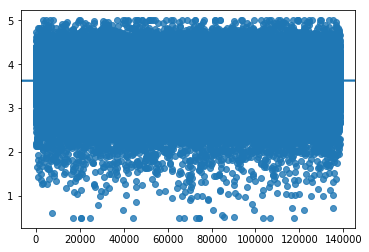

In [21]:
x = rating.groupby('userId')['rating'].mean().index.values
y = rating.groupby('userId')['rating'].mean().values
sns.regplot(x, y)

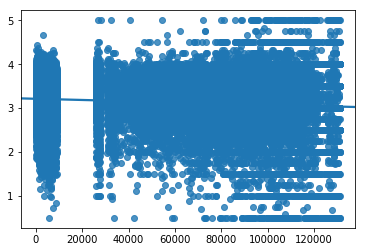

In [22]:
x = rating.groupby('movieId')['rating'].mean().index.values
y = rating.groupby('movieId')['rating'].mean().values
sns.regplot(x, y)

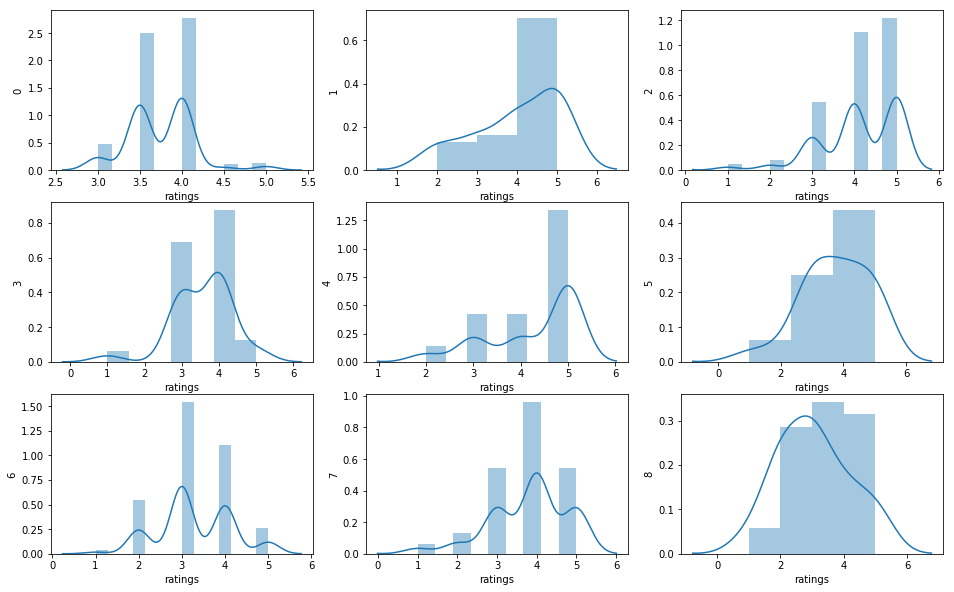

In [90]:
get_user = lambda id, data: data[data['userId'] == id]['rating']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))
for i in np.arange(9):
    sns.distplot(get_user(i + 1, rating), ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_xlabel('ratings')
    axes[i // 3, i % 3].set_ylabel(i)

Гипотеза подтвердилась, для каждого пользователя действительно своя средняя оценка, которая не приближенна к общей. Для фильмов распределение среднего уже больше похоже на общее среднее, но также имеет большой разброс.

Можно попробовать улучшить положение, если нормализовать оценки, а именно: для каждого пользователя из его оценки вычесть его среднюю оценку. Как изменится средняя оценка тогда:
$$
    \overline{r} = \frac{r_1 + r_2 + \ldots + r_n}{n}
$$$$
    \overline{r'} = \frac{(r_1 - \overline{r}) + \ldots + (r_n - \overline{r})}{n} = \overline{r} - \frac{n \times \overline{r}}{n} = 0
$$
Значит среднее станет 0, в нашей интерпретации это означает, что пользователи имеют одинаковое понимание средней оценки.

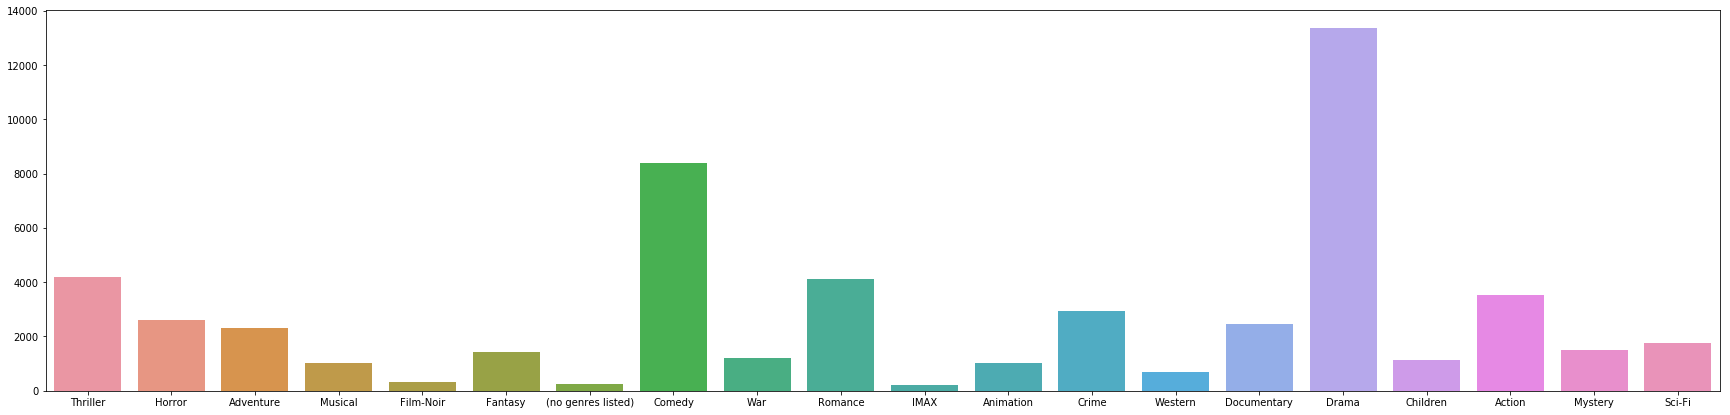

In [96]:
figure(figsize=(30, 7))
sns.barplot(list(genres), [len(i) for i in ids_genres])

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

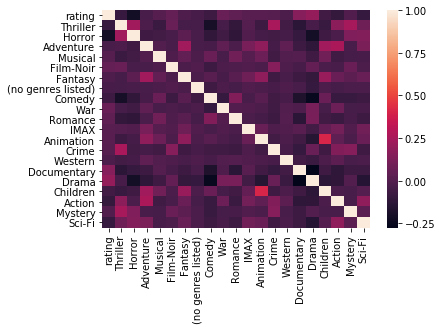

In [70]:
data = pd.DataFrame(rating.groupby('movieId')['rating'].mean()).reset_index()
for genre in tqdm_notebook(genres, total=len(genres)):
    data[genre] = data['movieId'].apply(lambda x: int(genre in movie.loc[x, 'genres']))
data.set_index('movieId', inplace=True)
sns.heatmap(data.corr('spearman'))

Существует корреляция между жанрами и рейтингом, но следует отметить, что и многие жанры между собой коррелируют, хотя значение корреляции мало.

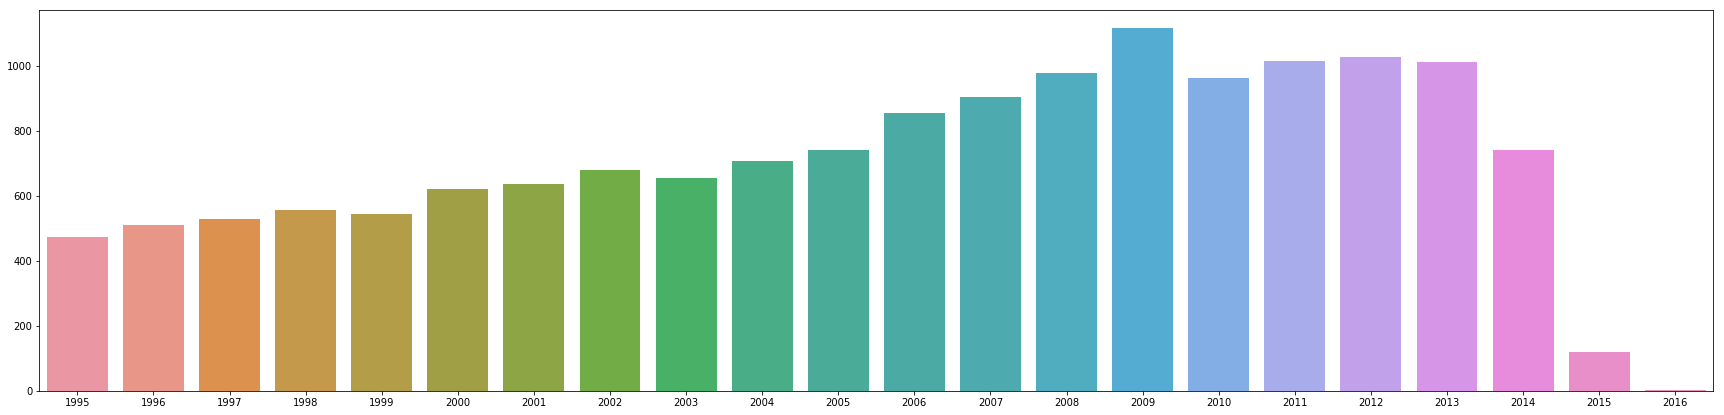

In [97]:
figure(figsize=(30, 7))
sns.barplot(years, [len(i) for i in ids_years])

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

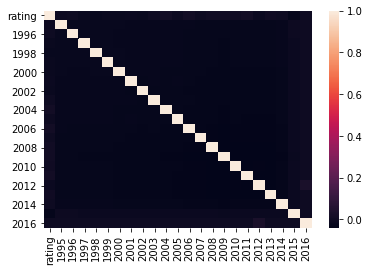

In [99]:
data = pd.DataFrame(rating.groupby('movieId')['rating'].mean()).reset_index()
for year in tqdm_notebook(years, total=len(genres)):
    data[year] = data['movieId'].apply(lambda x: int(str(year) in movie.loc[x, 'title']))
data.set_index('movieId', inplace=True)
sns.heatmap(data.corr('pearson'))

Корреляция крайне мала.

Посмотрим, сколько раз голосовали разные люди:
Так как значений очень много, то разделим на несколько категорий:
1. \>1000;
2. 500-1000;
3. 100-500;
4. 10-100;
5. 1-10;

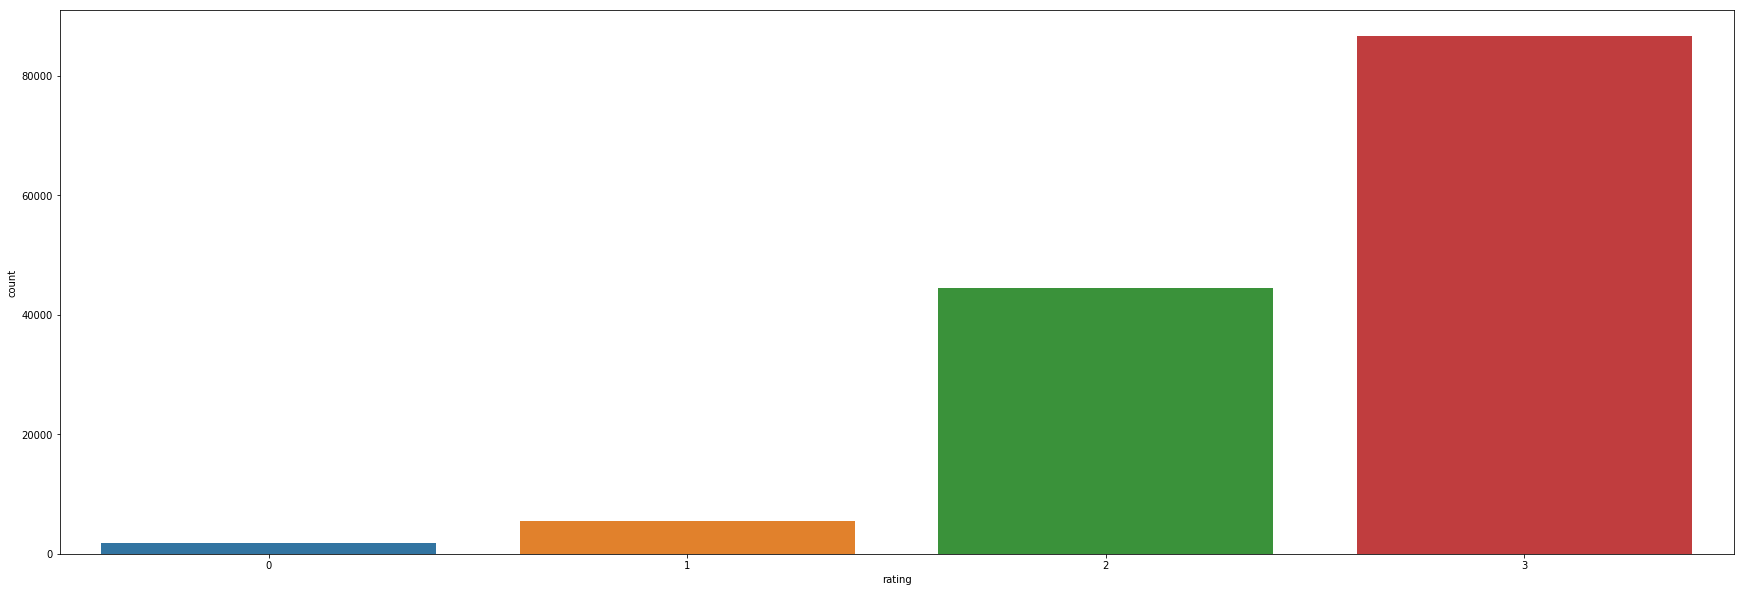

In [117]:
def cat(x):
    if x > 1000:
        return 0
    elif x > 500:
        return 1
    elif x > 100:
        return 2
    elif x > 10:
        return 3
    else:
        return 4
count = lambda x: cat(len(x))
    
data = rating.groupby('userId').agg({'rating': count}).astype(int)

figure(figsize=(30, 10))
sns.countplot('rating', data=data)

<b>Вывод:</b> для того, чтобы сравнивать двух пользователей или два фильма необходимо нормализовывать оценки, а именно вычитать из них среднюю оценку пользователя или предмета. Также существуют корреляции с некоторыми дополнительными данными.

### инсайты
1. Были обнаружены пропуски в для некоторых фильмов в колонке tmdb, это связано с тем, что некоторые фильмы есть на imdb, но нет на tmdb. Решение: расставить там -1, так как такого id нет, но мы хотим сохранить информацию о неизвестности + это категориальный признак. Больше пропусков нет, данные хорошие, чистые.
2. Были обнаружены корреляции между рейтингом и жанром фильма, но были опровергнуты между рейтингом и годом выпуска.
3. Данные подготовлены хорошо и аккуратно, большинство польователей совершали примерно равное число голосов.

Найденные факты очень важны, так, к примеру, дополнительные признаки могут улучшить контентные модели, где учитывается информация и ретроспектива прошлых действий. С другой стороны, при решение с помощью коллаборативной фильтрации, очень важно определять близость пользователей или фильмов, поэтому нормализация оценки сделает вычисление схожести приближенной к реальному отношению.

### метрика
Для задач предсказания оценки используются классические метрики регрессии: `MSE`, `RMSE` и `MAE`. Сейчас стандартом оценки качества является `RMSE`, которая приобрела большую популярность после [Netflix Prize](https://ru.wikipedia.org/wiki/Netflix_Prize). Такая метрика выбрана, так как при решение задачи с помощью линейных алгоритмов, например, `SVD`, нам необходимо минизировать функцию потерь, а среднеквадратичная ошибка хорошо для этого подходит.

Как уже было сказано, задача рекомендаций не заканчивается на построение прогнозов оценки, так как дать пользователи фильмы с наибольшей оценкой не всегда верно, именно поэтому иногда используют метрики ранжирования, например, `nDCG`, но так как мы ставим себе задачу именно предсказания оценки, то данный вариант не подходит.

Так же, в случаях двух возможных оценок, например, лайк и дизлайк, получаем задачу классификации, где используются уже стандартные метрики классификации: `Precision` и `Recall`. Но такой вариант также не подходит.

Таким образом, для оценки качества алгоритма будем использовать метрику `RMSE`. Её нет в пакете `sklearn`, но её легко получить с помощью встроенной `MSE`:

In [118]:
from sklearn.metrics import mean_squared_error
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))